# Chapter 2: k-armed Bandit

This is the first notebook of a series aimed at learning Reinforcement Learning through the book by Sutton and Barto: http://incompleteideas.net/book/the-book-2nd.html. It is meant to be a complement to each chapter, rather than a complete substitute.

However, I will try to make it as self-contained as possible, and keep the notations consistent with the book.


The goal of this notebook is to introduce a very simple reinforcement learning toy problem (k-armed bandit), and investigate different strategies to sample our action space 'efficiently'.

The k-armed bandit is a slot machine with k arms/levers; each arm yields a random reward following some unknown distribution. In this simple example, the distribution will be normal, and the reward will be sampled independently of the previous rewards, or arms activated.

The player will play N times, and his goal is to maximize the total reward. His controls are which arm to play at each trial, given past observations of the rewards for each arm.

Sampling our action space efficiently means that the player would like to use the arm yielding the highest reward all the time (exploitation). However, he does not know a priori which one it is since rewards are random, and hence has to try most of them to get a more precise idea on which arms yield better reward than others on average (exploration), and make sure he didn't miss a better arm. 

How do we choose actions to explore enough, but not waste too much of our trials in sub-optimal actions?

In [302]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
%matplotlib inline

## Building the environment

Let's first build our k-armed bandit; It has hard coded distributions of rewards, and we can play each arm

In [376]:
#Default parameters
default_k = 10 #default number of arms
default_dist = np.zeros((2,default_k))
default_dist[0,:] = np.abs(rd.normal(5,2,default_k)) #default mean reward for each arm
default_dist[1,:] = np.ones(default_k) #default variance of the reward for each arm

class Bandit:    
    def __init__(self,k=default_k,dist=default_dist):
        '''
        k: number of arms
        dist: mean and variances of the random gaussian rewards for each lever. 
        '''
        self.k = k
        self.dist = dist
        self.best_arm = np.argmax(self.dist[0,:])
        
    def play(self,a):
        '''Plays the lever a, and returns a reward distributed as a normal with
        mean dist[0,a] and variance dist[1,a]'''
        if a>=self.k:
            print('This arm does not exist, please use a value between 0 and',self.k-1)
        reward = max(rd.normal(self.dist[0,a], self.dist[1,a]),-1.0)
        return(reward)    

Now we have to create a player: Given the number of actions he is allowed to play, the player will start with a set of beliefs for each action: the estimated average reward $Q_0 = (Q_0(0),...,Q_0(k-1))$ for each arm $0,..,k-1$.

At each time $t$, the player will decide from $Q_t$ which action to take by doing the following: with probability $\epsilon$ explore (random action). Otherwise exploit and choose the estimated best action, given by $\arg \max_a Q_t(a)$.

The observed reward $R_t$ from playing action $a$ at time $t$ will allow the player to update his beliefs on the average rewards $Q$. More precisely, the player will do the following update for the estimated average reward for action $a$:
$$
Q_{t+1}(a) = Q_t(a) + \alpha (R_t - Q_t(a)) = \alpha R_t + (1-\alpha) Q_t(a)
$$
and leave the other $Q(a')$ unchanged.

We will allow the player to have some \emp{memory}, in which we can store past information (e.g. past rewards for each action, number of times we played an action etc.).

This memory will be used to decide how to update $Q$.

In [311]:
#Default parameters
default_q = np.zeros(default_k) #default estimates of the rewards
default_eps = 0.1 #default balance between exploration and exploitation
default_alpha = 0.1 #default rate of update in the estimates

class Player:
    def __init__(self,k=default_k,q=default_q,eps=default_eps, alpha = default_alpha):
        self.k = k #number of arms he can play
        self.q = q #estimates of the average reward for each arm
        self.eps = eps #exploitation vs exploration ratio
        self.alpha = alpha #rate of estimates update
        self.memory = None
    
    def action(self):
        '''Chooses the estimated best action with probability 1-eps, and random action otherwise'''
        best_a = np.argmax(self.q)
        u = rd.uniform()
        if u<1-self.eps:
            return(best_a)
        else:
            return(rd.choice(self.k))
        
    def update_q(self, a, reward):
        '''Updates the estimated rewards given an action a and its newly observed reward'''
        if a>= self.k:
            print('Error: the action does not exists')
        self.q[a] += self.alpha*(reward - self.q[a])

Note that both $\epsilon$ and $\alpha$ are inputs; we can change their values at each step if we desire so.

For example, a typical estimator $Q_t(a)$ for the average reward of arm $a$ is:
$$
Q_t(a) = \frac{1}{N_t(a)} \sum_{i=1}^{t} R_i \mathbb{1}_{A_i = a} 
$$
where $N_t(a)$ is the number of times we played action $a$ at up to time $t$, and $A_i$ is the action chosen at time $i$.

One can easily check that this corresponds to a choice $\alpha_t = 1/N_t(a)$ in our updating scheme.

In that case, one has to store a list of $N_t(a)$ in the memory of the player.

On the other hand, keeping $\alpha$ constant corresponds to an exponential decay of our memory (past rewards won't matter much in our beliefs of average rewards).

Similarly, one can decide to take $\epsilon$ to be constant (called $\epsilon$-greedy strategy), or exploit more and more the further we advance in the game and take $\epsilon_t = 1 - t/N$ at step $t$.

## First run

Let's do a first test, and plot the performance of a player that chooses an $\epsilon$-greedy strategy and a standard arithmetic average of estimated rewards.

The player's performance will be measured by the percentage of actions took up to time $t$ which agree with the best action.

In this game, we will only save in memory the number of times each action has been played.

In [349]:
#Define a game
def game(bandit,player,N):
    '''Given a slot machine bandit, a player and a number of trials N,
    returns the perfomance of a player'''
    k = bandit.k
    best_arm = bandit.best_arm
    perc_best_arm = [0] # % of choices for the best arm at each iteration
    total_reward = [0]; #total rewards up to time t
    
    for n in range(N):
        #Choose an action
        player.eps = 0.1 #update exploration vs exploitation scheme; EXPERIMENT!
        a = player.action()
        player.memory[a] += 1.0 #increment counter for that action
        perc_best_arm.append(player.memory[best_arm]/(n+1))
        
        #play
        reward = bandit.play(a)
        total_reward.append(total_reward[-1] + reward)
        
        #Update beliefs on average Rewards Q
        player.alpha = 1.0/player.memory[a] #update weighting scheme of rewards; EXPERIMENT!
        player.update_q(a,reward)
        
    return(perc_best_arm, total_reward)   

Let's plot the performace of the player for this strategy to make sure our game function works:

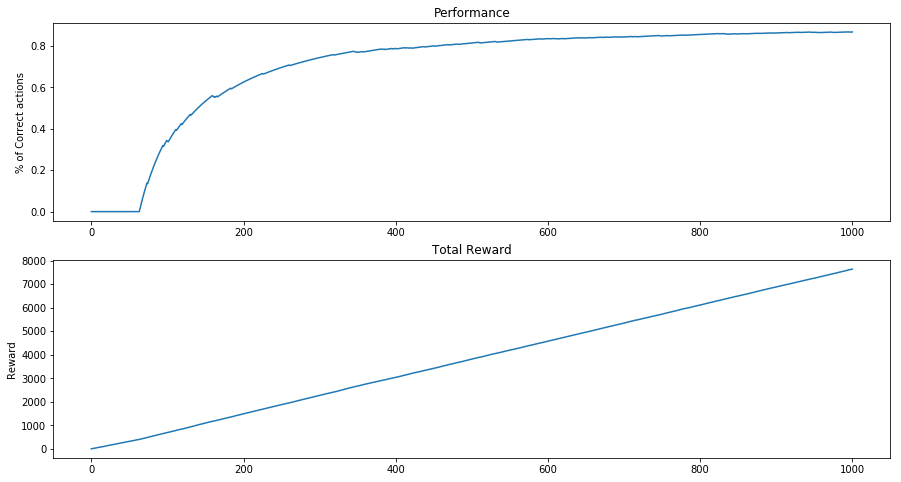

In [403]:
#Number of trials
N = 1000 

#Create a slot machine (default initialization)
bandit1 = Bandit()
k = bandit1.k

#Create a player
player1 = Player(k,np.zeros(k)) #Q initialized to 0 for all actions 
player1.memory = np.zeros(k) #store the list of the number of times an action is played in memory

#Play!
perf, reward = game(bandit1,player1,N)

#plot
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,8))

ax1.set(title='Performance', ylabel='% of Correct actions')
ax1.plot(perf);

ax2.set(title='Total Reward', ylabel='Reward')
ax2.plot(reward);

Let's do 50 trials and plot each player's performance

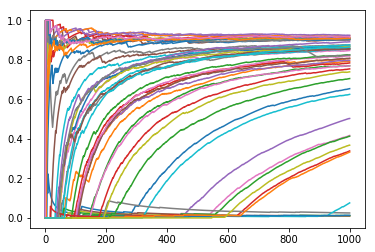

In [411]:
k=10 #arms
N = 1000 #trials

for n in range(50):
    #Create a slot machine
    dist = np.ones((2,k))
    dist[0,:] = np.abs(rd.normal(5,1,k))
    bandit = Bandit(k,dist)
    
    #Create a player
    player = Player(k,np.zeros(k))  
    player.memory = np.zeros(k) 
    
    #Play the game and plot the performance
    plt.plot(game(bandit,player,N)[0]);

Exercise: Change the values of $\epsilon$ and $\alpha$ (either different constants, or different updating schemes) in the game function and plot the new performance